**Di Luo**

Spring 2020

CS 251: Data Analysis and Visualization

Project 6: Supervised learning

In [16]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Project 6) Supervised learning

The overall goal of this project is to implement an email spam filter to determine whether an email is spam (*spam*) or not (*ham*). You will implement and compare the performance of two supervised learning algorithms: **K Nearest Neighbors (KNN)** and **Naive Bayes**.

## Task 1: K Nearest Neighbors (KNN) Classifier

To start off the project, you will implement the **KNN classifier**, a bedrock, highly-versatile, nonparametric (i.e. *memory-based*) supervised learning algorithm. You will test out and experiment with KNN on a **multi-class spiral 2D test dataset**.

### 1a) Load and visualize spiral data

- Below, load in both spiral datasets 1 (`spiral_train_1.csv`, `spiral_test_1.csv`) and 2 (`spiral_train_2.csv`, `spiral_test_2.csv`). Each training set has 4,000 samples and each test set has 1,200 samples.
- Create a 2x2 grid plot showing the train and test data side-by-side in each version of the dataset.
    - Be sure to label your subplots with informative titles (which datset are we looking at?).
    - Color-code the points based on their class.
    - Set the figure size to make everything clearly legible (not microscopic).

#### Format of spiral data

- Column 1: x coordinate of a 2D point (on a spiral).
- Column 2: y coordinate of a 2D point (on a spiral).
- Column 3: class. Which spiral arm does the point belong to? Labels: [0, 1, 2, 3]

In [17]:
spiral_1_train = np.loadtxt('data/spiral_train_1.csv', skiprows=1, delimiter=',')
spiral_1_test = np.loadtxt('data/spiral_test_1.csv', skiprows=1, delimiter=',')
spiral_2_train = np.loadtxt('data/spiral_train_2.csv', skiprows=1, delimiter=',')
spiral_2_test = np.loadtxt('data/spiral_test_2.csv', skiprows=1, delimiter=',')

spiral_1_train_y = spiral_1_train[:, 2]
spiral_1_test_y = spiral_1_test[:, 2]
spiral_2_train_y = spiral_2_train[:, 2]
spiral_2_test_y = spiral_2_test[:, 2]

spiral_1_train = spiral_1_train[:, :2]
spiral_1_test = spiral_1_test[:, :2]
spiral_2_train = spiral_2_train[:, :2]
spiral_2_test = spiral_2_test[:, :2]

print(f'Spiral 1 train {spiral_1_train.shape}, classes {spiral_1_train_y.shape}')
print(f'Spiral 1 test {spiral_1_test.shape}, classes {spiral_1_test_y.shape}')
print(f'Spiral 2 train {spiral_2_train.shape}, classes {spiral_2_train_y.shape}')
print(f'Spiral 2 test {spiral_2_test.shape}, classes {spiral_2_test_y.shape}')

Spiral 1 train (4000, 2), classes (4000,)
Spiral 1 test (1200, 2), classes (1200,)
Spiral 2 train (4000, 2), classes (4000,)
Spiral 2 test (1200, 2), classes (1200,)


Text(0, 0.5, 'y')

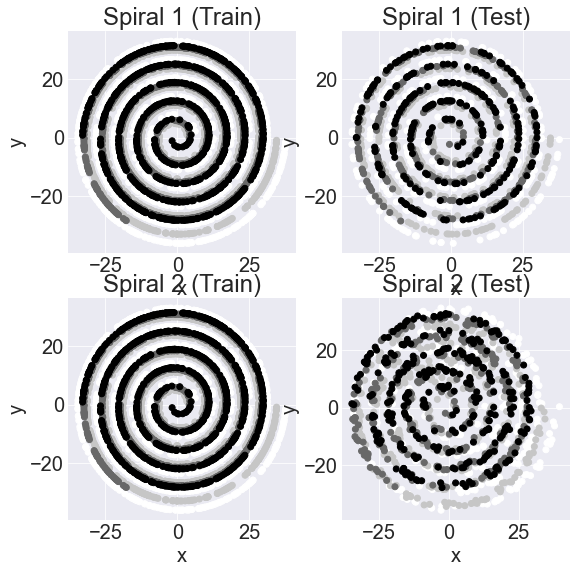

In [18]:
# Plot your spirals here
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

axes[0, 0].scatter(spiral_1_train[:, 0], spiral_1_train[:, 1], c=spiral_1_train_y)
axes[0, 0].set_title('Spiral 1 (Train)')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')

axes[0, 1].scatter(spiral_1_test[:, 0], spiral_1_test[:, 1], c=spiral_1_test_y)
axes[0, 1].set_title('Spiral 1 (Test)')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')

axes[1, 0].scatter(spiral_2_train[:, 0], spiral_2_train[:, 1], c=spiral_2_train_y)
axes[1, 0].set_title('Spiral 2 (Train)')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')

axes[1, 1].scatter(spiral_2_test[:, 0], spiral_2_test[:, 1], c=spiral_2_test_y)
axes[1, 1].set_title('Spiral 2 (Test)')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')

### 1b) Implement KNN

Implement the following methods in `knn.py`. Test relevant methods using the test code below.

- Constructor
- `train(data, y)`: Train the KNN classifier on the data `data`, where training samples have corresponding class labels in `y`.
- `predict(data, k)`: Use the trained KNN classifier to predict the class label of each test sample in `data`. Determine class by voting: find the closest `k` training exemplars (training samples) and the class is the majority vote of the classes of these training exemplars.
- `accuracy(y, y_pred)`: Compute percent correct given true data labels `y` and algorithm predicted labels `y_pred`. 

In [19]:
from knn import KNN

#### Test: Accuracy

In [20]:
np.random.seed(0)
test_y = np.random.randint(low=0, high=11, size=(50,))
test_y_pred = np.random.randint(low=0, high=11, size=(50,))

classifier = KNN(num_classes=0)
acc = classifier.accuracy(test_y, test_y_pred)
print(f'Test accuracy is {acc} and should be 0.06.')

Test accuracy is 0.06 and should be 0.06.


#### Test: 1-KNN

In [21]:
n_classes = 4
classifier = KNN(num_classes=n_classes)
classifier.train(spiral_1_train, spiral_1_train_y)

k = 1
spiral_1_y_pred = classifier.predict(spiral_1_train, k)
acc = classifier.accuracy(y=spiral_1_train_y, y_pred=spiral_1_y_pred)
print(f'Your accuracy with K=1 is {acc} and should be 1.0')

Your accuracy with K=1 is 1.0 and should be 1.0


**Question 1:** Explain why in the above test, the accuracy must be 100%.

**Answer 1:** We use the training data when we are predicting so data points in testing set should find the exact same value.

#### Test 2-KNN

*Note: The below test code assumes that you resolve voting ties with the class that has a lower index. The numpy function that you may use to return the index of the class that has the most votes may handle this automatically for you.*

In [22]:
n_classes = 4
classifier = KNN(num_classes=n_classes)
classifier.train(spiral_1_train, spiral_1_train_y)

k = 2
spiral_1_y_pred = classifier.predict(spiral_1_test, k)
acc = classifier.accuracy(y=spiral_1_test_y, y_pred=spiral_1_y_pred)
print(f'Your accuracy with K=2 is {acc:.2f} and should be 0.88')

true_test_y = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
       1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

print(f'The mismatches between your predicted class of test samples 250-500 and the expected values are\n{np.where(true_test_y != spiral_1_y_pred[249:500], 1, 0)}')
print('Seeing all 0s means everything seems to be working great!')

Your accuracy with K=2 is 0.88 and should be 0.88
The mismatches between your predicted class of test samples 250-500 and the expected values are
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Seeing all 0s means everything seems to be working great!


### 1c) Find the best `k`

- Below, "script" your `predict` method on both spiral datasets 1 and 2. Compute the accuracy on the respective test sets with many different values of `k`.
- Create two well-labeled plots, one for each spiral dataset, showing the accuracy for many different `k` values.

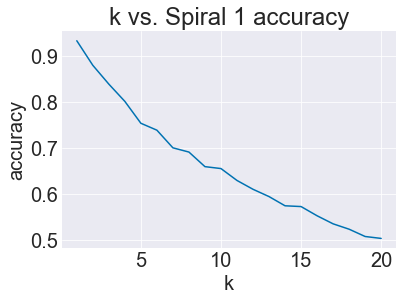

In [23]:
# Spiral 1 results here
kmax = 20
accurate = np.zeros((kmax))
for i in range(1, kmax+1):
    classifier = KNN(num_classes=n_classes)
    classifier.train(spiral_1_train, spiral_1_train_y)
    spiral_1_y_pred = classifier.predict(spiral_1_test, i)
    accurate[i-1] = classifier.accuracy(y=spiral_1_test_y, y_pred=spiral_1_y_pred)
plt.plot(np.arange(1,kmax+1), accurate)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('k vs. Spiral 1 accuracy')
plt.show()

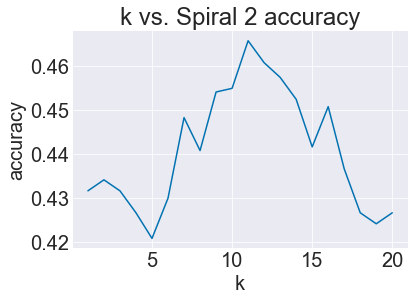

In [24]:
# Spiral 2 results here
kmax = 20
accurate = np.zeros((kmax))
for i in range(1, kmax+1):
    classifier = KNN(num_classes=n_classes)
    classifier.train(spiral_2_train, spiral_2_train_y)
    spiral_2_y_pred = classifier.predict(spiral_2_test, i)
    accurate[i-1] = classifier.accuracy(y=spiral_2_test_y, y_pred=spiral_2_y_pred)
plt.plot(np.arange(1,kmax+1), accurate)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('k vs. Spiral 2 accuracy')
plt.show()

**Question 2:** What is the `k` that results in the highest accuracy on each spiral dataset?

**Answer 2:** Spiral 1: k=1; spiral 2: k=11.

**Question 3:** Give at least one "good" reason why the accuracies are so different across the datasets. (*Hint: look at the data*)

**Answer 3:** Training set and testing set in Spiral 1 are similar in terms of general shape, where as those 2 of spiral 2 are very different.

**Question 4:** Give at least one "good" reason why the best `k` values are so different across the datasets.

**Answer 4:** Smaller k in spiral 1 since distance between points in testing set and those in training set are small, and the small change led to small k. For spiral 2, greater variation leds to bigger distance so that k should be greater.

**Question 5:** What does it mean to have such different best `k` values when it comes to determining the class of a data sample?

**Answer 5:** Larger k means more classes are needed. 

**Question 6:** Is it a good idea to always set `k` to one of these values when working with another dataset?

**Answer 6:** No, it depends on the shape of the dataset.

**Question 7:** Would you expect that linear regression performed on the data belonging to one class of the spiral data to be successful? Briefly describe the advantages of the better approach (KNN or linear regression) given the properties of the dataset.

**Answer 7:** No because linear regression is better when working with datasets with continuous output but KNN is better with discrete output.

### 1d) Visualize class boundaries

- Implement `plot_predictions` in `knn.py` to visualize how different regions of the (2D) dataspace would be classified. In this visualization, use four discrete colors to represent each of the classes. For example, if KNN would classify (x, y) = (10, 10) to spiral 2, you would color that region blue (for example). You will repeat this for lots of different regularly spaced x,y points to get a better picture of the regions that would be predicted to belong to different classes.
- Pick spiral dataset 1 or 2, then create 2-3 plots of the class boundaries with several different k values.

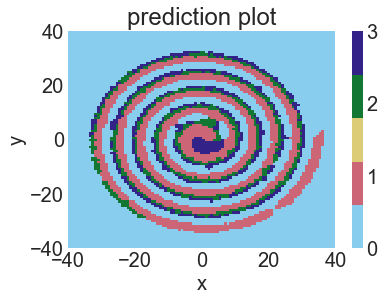

In [28]:
# Visualize KNN boundary 1
classifier = KNN(num_classes=n_classes)
classifier.train(spiral_1_train, spiral_1_train_y)
classifier.plot_predictions(2,100)

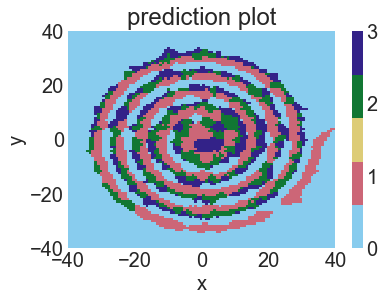

In [29]:
# Visualize KNN boundary 2
classifier = KNN(num_classes=n_classes)
classifier.train(spiral_1_train, spiral_1_train_y)
classifier.plot_predictions(8,100)

**Question 8:** Describe the classification pattern for the different `k` values, and interpret relative to the best `k` accuracy values that you found above.

**Answer 8:** When k=2, spiral is more like original graph, so it's better since it is closer to the original graph.

## Task 2: Spam email preprocessing (Section B only)

**Sections A/C:** 

You have been supplied with Numpy-friendly email datasets on Classroom. 

*You should still read this section so that you understand how these datasets have been formatted,* but do not have to complete Task 2.

**Section B:**

Before you can build a spam email filter, you need to transform the email data into a suitable format so that KNN or other supervised learning algorithms can process them (this is called **preprocessing**).

In this project, you will work with the **Enron email dataset**, a large datset consisting of ~34,000 emails. Enron is an energy company that famously went bankrupt in the early 2000s after committing massive accounting fraud (more info: https://en.wikipedia.org/wiki/Enron). The US government seized company emails during their investigation and they were released to the public much later and nowadays is a commonly used datset in machine learning. 

Your eventual goal will be to train a supervised learning algorithm on some of the emails and predict whether the remaining ones are spam or not.

But first...onto the preprocessing!

### Overall preprocessing strategy

We need to turn each email's text into something an algorithm can process (**features**). We will use a simple type of feature: **bag of words counts**. That is, we will reduce an email into a vector of how many times words appeared in it.

*Problem:* There are too many words across all the emails. Processing the counts in each email would take too long. For example, there are more than 40,000 words across all the emails. If we were trying to predict whether 1,000 emails are spam or not, we would need to build a `1000 x 40000` matrix (count each of the 40,000 words in each of the 1,000 emails), which would take a very long time to process by the supervised learning algorithm. 

A work-around that works quite well is to restrict ourselves to the most frequent $W$ words in the email dataset. You can experiment with how many words to include (e.g. as an extension), but for concreteness we will set this $W=200$ in the core project. In the above example, we can then process `1000 x 200` matrix much more quickly.

### 2a) Determine email word frequency

- Download and extract the Enron emails from filer. You should see a base `enron` folder, with `spam` and `ham` subfolders (these are the 2 classes), and documents in each with the raw email text.
- In `email_preprocessor.py` implement `count_words(email_path)` to build up a python dictionary of all the words in the dataset (keys) and their associated counts (values).
- Write `find_top_words(word_freq)` to parse the dictionary and determine the top $W$ words.

In [33]:
import email_preprocessor as epp

#### Test `count_words` and `find_top_words`

In [34]:
word_freq, num_emails = epp.count_words()

In [35]:
print(f'You found {num_emails} emails in the datset. You should have found 33702.')

You found 0 emails in the datset. You should have found 33702.


In [36]:
top_words, top_counts = epp.find_top_words(word_freq)
print(f"Your top 5 words are\n{top_words[:5]}\nand they should be\n['the', 'to', 'and', 'of', 'a']")
print(f"The associated counts are\n{top_counts[:5]}\nand they should be\n[290748, 213001, 157468, 148447, 118159]")

Your top 5 words are
[]
and they should be
['the', 'to', 'and', 'of', 'a']
The associated counts are
[]
and they should be
[290748, 213001, 157468, 148447, 118159]


### 2b) Make feature vectors based only on the top word counts

- Implement `make_feature_vectors`: Go back through the email folder structure and parse each email again. Now only count the frequency of words that are in the top $W$ word list. Keep track of whether each of these feature vectors are associated with a spam or not spam email.

In [ ]:
features, y = epp.make_feature_vectors(top_words, num_emails)

Note: You may need to replace the index `0` in `features[0,:10]` in the cell below if you processed your emails in a different order. The first email is here assumed to be `4743.2005-06-25.GP.spam.txt`

In [ ]:
print(f'Your matrix of features has shape {features.shape} and it should be (33702, 200).')
print(f'Your class label vector has shape {y.shape} and it should be (33702,).')
print(f'Your 1st few counts in your first feature vector (from 4743.2005-06-25.GP.spam.txt) are:\n{features[0,:10]}\n and it should be:\n[5. 4. 4. 1. 4. 1. 4. 3. 0. 1.]\nFor debugging, it may be helpful to remember that the first 5 slots correspond to the counts for the words:\n[the, to, and, of, a]\n')
print(f'The classes of the 1st few emails are\n{y[:5]}\nand should be\n[0. 0. 0. 0. 0.]\n\nThe last few email labels are\n{y[-5:]}\nand should be\n[1. 1. 1. 1. 1.]')

### 2c) Make train and test splits of the dataset

- Your matrix of features is for the entire dataset. We can't train the classifier on all these because then we won't have any emails left over to see how well your model's ability to discriminate spam/ham email generalizes to emails not seen during training. Like in the spiral dataset, implement `make_train_test_sets` to divide the email features into a 80/20 train/test split (80% of data used to train the supervised learning model, 20% we withhold and use for testing / prediction).

In [ ]:
np.random.seed(0)
x_train, y_train, inds_train, x_test, y_test, inds_test = epp.make_train_test_sets(features, y)

In [ ]:
print('Shapes for train/test splits:')
print(f'Train {x_train.shape}, classes {y_train.shape}')
print(f'Test {x_test.shape}, classes {y_test.shape}')
print('They should be:\nTrain (26962, 200), classes (26962,)\nTest (6740, 200), classes (6740,)')

### 2d) Save data in binary format

It add a lot of overhead to have to run through your raw email -> train/test feature split every time you wanted to work on your project! In this step, you will export the data in memory to disk in a binary format. That way, you can quickly load all the data back into memory (directly in ndarray format) whenever you want to work with it again. No need to parse from text files!

- Use numpy's `save` function to make six files in `.npy` format (e.g. `email_train_x.npy`, `email_train_y.npy`, `email_train_inds.npy`, `email_test_x.npy`, `email_test_y.npy`, `email_test_inds.npy`).

In [ ]:
np.save('data/email_train_x.npy', x_train)
np.save('data/email_train_y.npy', y_train)
np.save('data/email_train_inds.npy', inds_train)
np.save('data/email_test_x.npy', x_test)
np.save('data/email_test_y.npy', y_test)
np.save('data/email_test_inds.npy', inds_test)